In [1]:
library(dplyr)
library(tidyr)
library(tidyverse)
library(sf)
library(MatchIt)
library(fixest)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.1     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.1.8
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1; sf_use_s2() is TRUE



## 1. Add Tree Loss

In [2]:
# Load matching frame
mf = st_read(file.path("/kaggle/input/mf-rbase-1km-mdg/mf_rBase_1km_Madagascar.gpkg")) %>%
  filter(group==0 | group==1) %>%
  st_drop_geometry()

Reading layer `mf_rBase_1km_Madagascar' from data source 
  `/kaggle/input/mf-rbase-1km-mdg/mf_rBase_1km_Madagascar.gpkg' 
  using driver `GPKG'
Simple feature collection with 591917 features and 29 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 313074.7 ymin: 7167908 xmax: 1089075 ymax: 8675908
Projected CRS: WGS 84 / UTM zone 38S


In [3]:
# The calculation of tree loss area is performed at dataframe base
# Get the column names of tree cover time series
colnames_tree = names(mf)[startsWith(names(mf), "fc")]
# Drop the first year
dropFirst = tail(colnames_tree, -1)
# Drop the last year
dropLast = head(colnames_tree, -1)
# Set list of new column names for tree loss time series
colnames_loss = dropFirst %>% str_split(., "_")
# Add new columns: treeloss_tn = treecover_tn - treecover_t(n-1)  
for (i in 1:length(dropFirst)) {
  new_colname <- paste0("treeloss_pct_", colnames_loss[[i]][3])
    # Calc absolute value of Year_t - Year_(t-1) 
  mf[[new_colname]] <- abs(mf[[dropFirst[i]]] - mf[[dropLast[i]]])
}

In [4]:
# Add column: average treeloss before funding starts, i.e. avg. of treeloss from 2001 to 2006
mf$avgLoss_pre_fund = round(rowMeans(mf[grepl("treeloss", names(mf))][1:6]), 2)

## 2a. Matching

* Good Balance when,
`Std. Mean Diff` and `eCDF stats` close to **`0`** and `variance ratios` close to **`1`**.

* `Std.Pair Diff` displays the average absolute within-pair difference of each covariate. when they're small, better balance, and estimated effects are more robust to misspecification of the outcome model.

In [5]:
# Make cut-off list ####
lst_cutoffs = c()

# Quantile in 8 parts
lst_cutoffs$accessiblity_min = as.integer(quantile(mf$accessiblity_min, probs = seq(0, 1, 0.05), na.rm=TRUE))

#lst_cutoffs$clay_._mean_0_20 = as.integer(quantile(mf$clay_._mean_0_20, probs = seq(0, 1, 0.05), na.rm=TRUE))
lst_cutoffs$clay_._mean_0_20 = as.integer(c(0,10,20,30, 32,34,36,38,40, 50,60,70,80,90,100))

lst_cutoffs$elevation_m = as.integer(quantile(mf$elevation_m, probs = seq(0, 1, 0.1), na.rm=TRUE))

lst_cutoffs$TRI = as.integer(quantile(mf$TRI, probs = seq(0, 1, 0.1), na.rm=TRUE))

lst_cutoffs$fc_._2000 = as.integer(quantile(mf$fc_._2000, probs = seq(0, 1, 0.025), na.rm=TRUE))

lst_cutoffs$avgLoss_pre_fund = as.integer(quantile(mf$avgLoss_pre_fund, probs = seq(0, 1, 0.005), na.rm=TRUE))

In [6]:
# CEM Match
out.cem = matchit(group ~ accessiblity_min + clay_._mean_0_20 +
                   
                   elevation_m + TRI + 
                   
                   fc_._2000 + avgLoss_pre_fund,
                 
                 data = mf, method = "cem", cutpoints = lst_cutoffs)

In [7]:
# Summary of matching output
summary(out.cem)


Call:
matchit(formula = group ~ accessiblity_min + clay_._mean_0_20 + 
    elevation_m + TRI + fc_._2000 + avgLoss_pre_fund, data = mf, 
    method = "cem", cutpoints = lst_cutoffs)

Summary of Balance for All Data:
                 Means Treated Means Control Std. Mean Diff. Var. Ratio
accessiblity_min      663.5408      500.5487          0.4554     1.3722
clay_._mean_0_20       30.6966       25.9559          1.0156     0.9753
elevation_m           524.1942      544.7599         -0.0575     0.6303
TRI                    44.7896       29.0770          0.5575     1.5729
fc_._2000              93.0923       53.7427          2.0024     0.2977
avgLoss_pre_fund        0.0478        0.0855         -0.1515     0.3896
                 eCDF Mean eCDF Max
accessiblity_min    0.0829   0.1850
clay_._mean_0_20    0.1102   0.4150
elevation_m         0.0352   0.0882
TRI                 0.0859   0.2593
fc_._2000           0.3931   0.5751
avgLoss_pre_fund    0.0039   0.1643

Summary of Balance for Mat

## 2b. Plot Histogramm

**Black line --> Treatment, Grey line --> Control**

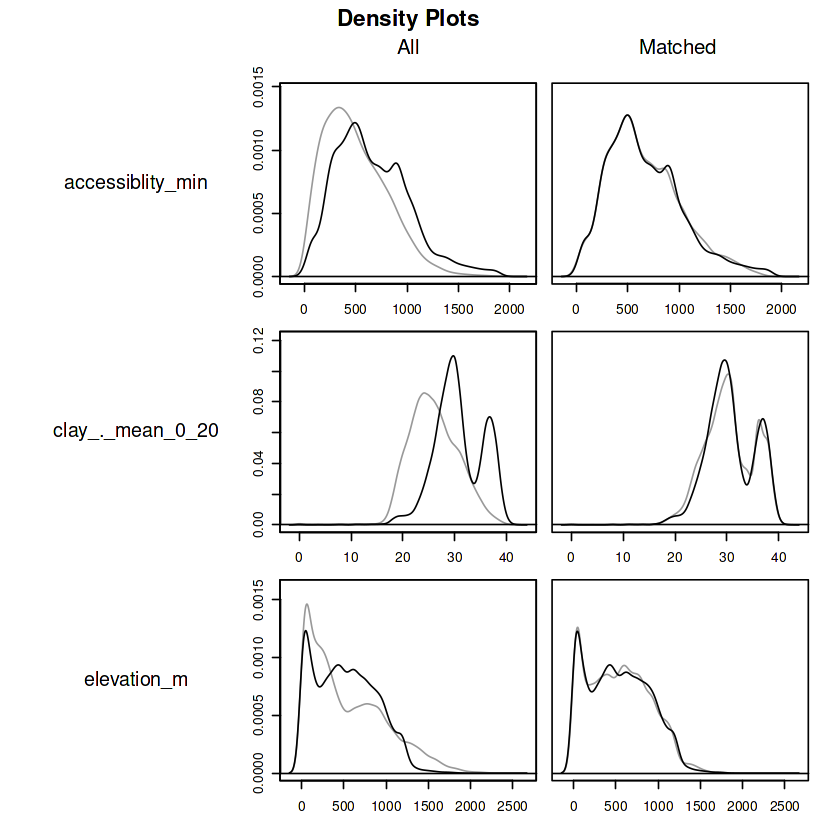

In [8]:
# Plot ####
plot(out.cem, type = "density", interactive = FALSE,
     which.xs = c("accessiblity_min", "clay_._mean_0_20", "elevation_m"))

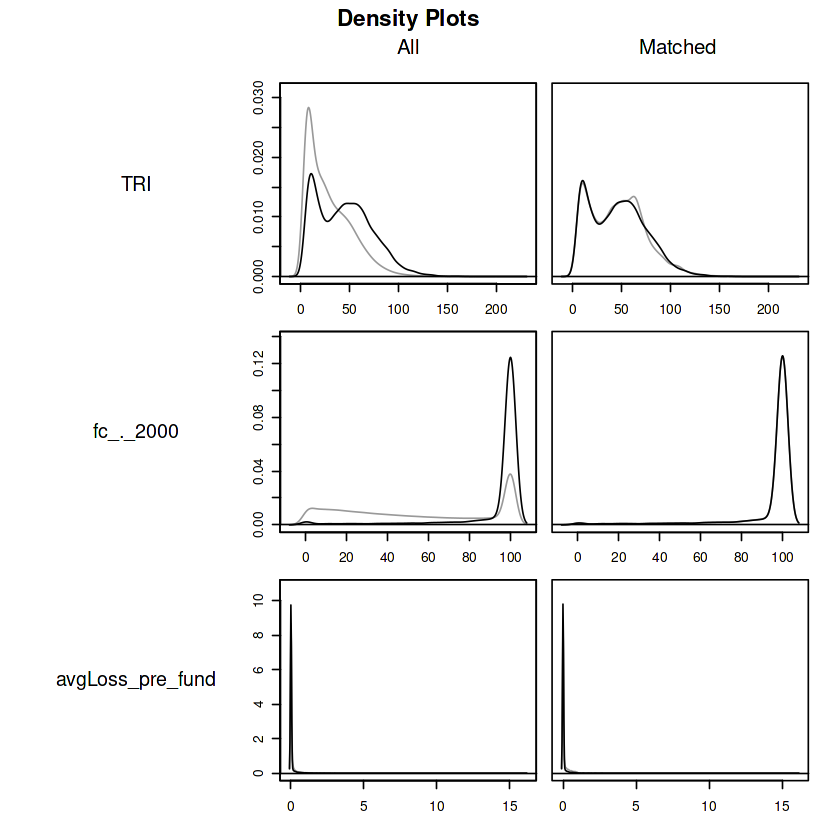

In [9]:
plot(out.cem, type = "density", interactive = FALSE,
     which.xs = c("TRI", "fc_._2000", "avgLoss_pre_fund"))

## 3. Panelize Matched Dataframe

In [10]:
# Pivot DF of matched objects
matched.wide = match.data(object=out.cem, data=mf)
print(paste0("The total number of matched items: ", as.character(nrow(matched.wide))))

head(matched.wide)

[1] "The total number of matched items: 70952"


,gridID,group,wdpaid,fc_._2000,fc_._2001,fc_._2002,fc_._2003,fc_._2004,fc_._2005,fc_._2006,⋯,treeloss_pct_2015,treeloss_pct_2016,treeloss_pct_2017,treeloss_pct_2018,treeloss_pct_2019,treeloss_pct_2020,treeloss_pct_2021,avgLoss_pre_fund,weights,subclass
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
588,1072,0,0,25.4,25.4,25.4,25.4,25.4,25.4,25.0,⋯,0,0.2,0,0,0,0.1,0.4,0.07,0.2265444,1
591,1075,0,0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,⋯,0,0.0,0,0,0,0.0,0.0,0.00,0.4153313,2
665,1165,0,0,0.8,0.8,0.8,0.8,0.8,0.8,0.8,⋯,0,0.0,0,0,0,0.0,0.0,0.00,0.4153313,2
737,1240,0,0,25.7,25.7,25.7,25.7,25.7,25.7,24.8,⋯,0,0.0,0,0,0,0.0,0.0,0.15,0.2265444,1
823,1329,0,0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,⋯,0,0.0,0,0,0,0.0,0.0,0.00,1.2459939,3
824,1330,0,0,39.4,39.4,39.4,39.4,39.4,39.4,39.4,⋯,0,0.2,0,0,0,0.0,0.0,0.00,4.9839757,4


In [11]:
# Average treecover 2000 of matched treatment group, identical with CEM summary
matched.wide %>%
    filter(group==1) %>% select(c(fc_._2000)) %>%
    summarise(across(everything(), mean))

fc_._2000
<dbl>
93.63172


In [12]:
# Average treecover 2000 of matched control group, NOT identical with CEM summary!
matched.wide %>%
    filter(group==0) %>% select(c(fc_._2000)) %>%
    summarise(across(everything(), mean))

fc_._2000
<dbl>
91.80747


In [13]:
# Pivot Wide ==> Pivot Long
matched.long = matched.wide %>%
    select(c(group, wdpaid, gridID, weights, starts_with("fc"))) %>%
    pivot_longer(cols = c(starts_with("fc")),
                 names_to = c("var", "year"),
                 names_sep = "_._",
                 values_to = "fc_pct")

In [14]:
head(matched.long)

group,wdpaid,gridID,weights,var,year,fc_pct
<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>
0,0,1072,0.2265444,fc,2000,25.4
0,0,1072,0.2265444,fc,2001,25.4
0,0,1072,0.2265444,fc,2002,25.4
0,0,1072,0.2265444,fc,2003,25.4
0,0,1072,0.2265444,fc,2004,25.4
0,0,1072,0.2265444,fc,2005,25.4


## 4. Plotting

In [15]:
# DF for plotting Trend
df_plotTrend = matched.long %>%
    group_by(group, year) %>%
    summarise(fc_avg = mean(fc_pct, na.rm=TRUE), n = n())
df_plotTrend

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


group,year,fc_avg,n
<dbl>,<chr>,<dbl>,<int>
0,2000,91.80747,59095
0,2001,91.78014,59095
0,2002,91.73247,59095
0,2003,91.67689,59095
0,2004,91.58409,59095
0,2005,91.47301,59095
0,2006,91.40350,59095
0,2007,90.93435,59095
0,2008,90.61937,59095


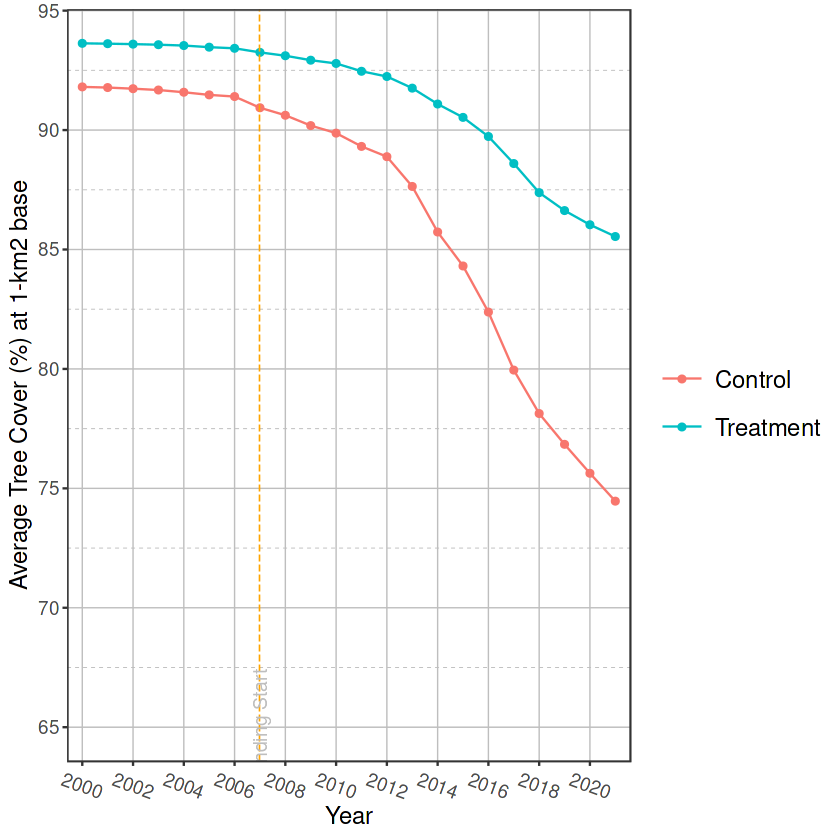

In [16]:
# Trend Plot
ggplot(df_plotTrend, 
       aes(x = year, y = fc_avg)) +
    geom_line(aes(group = group, color = as.character(group))) +
    geom_point(aes(color = as.character(group))) +
    geom_vline(aes(xintercept = "2007"), linetype = "longdash", color="orange", linewidth = 0.35) +
    #geom_text(aes(x="2007", label="Start of funding", y=75), colour="orange", angle=90, text=element_text(size=10)) +
    annotate("text", x="2007", y=65, label="Funding Start", angle=90, size=4, color="grey") +

    #scale_y_continuous(breaks=seq(0,100,10), labels=paste(seq(0,100,10)),
    #                   expand=c(0,0), limits=c(0,100)) +
    scale_x_discrete(breaks=seq(2000,2020,2), labels=paste(seq(2000,2020,2))) +
    scale_color_hue(labels = c("Control", "Treatment")) +

    labs(x = "Year", y = "Average Tree Cover (%) at 1-km2 base", color = "Group") +
    #coord_fixed() +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle = -20, hjust = 0.5, vjust = 0.5),
        axis.text=element_text(size=11),
        axis.title=element_text(size=14),
        
        #legend.position = "bottom",
        legend.title = element_blank(),
        legend.text=element_text(size=14),
        #legend.spacing.x = unit(1.0, 'cm'),
        legend.spacing.y = unit(0.75, 'cm'),
        legend.key.size = unit(2, 'line'),

        panel.grid.major.x = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
        panel.grid.minor.x = element_line(color = 'grey', linewidth = 0.2, linetype = 2),
        panel.grid.major.y = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
        panel.grid.minor.y = element_line(color = 'grey', linewidth = 0.2, linetype = 2)

    )


## 5. Regression

In [17]:
head(matched.long)

group,wdpaid,gridID,weights,var,year,fc_pct
<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>
0,0,1072,0.2265444,fc,2000,25.4
0,0,1072,0.2265444,fc,2001,25.4
0,0,1072,0.2265444,fc,2002,25.4
0,0,1072,0.2265444,fc,2003,25.4
0,0,1072,0.2265444,fc,2004,25.4
0,0,1072,0.2265444,fc,2005,25.4


In [18]:
feols(fc_pct ~ group | year,
      data = matched.long, 
      weights = matched.long$weights)

OLS estimation, Dep. Var.: fc_pct
Observations: 1,560,944 
Weights: matched.long$weights 
Fixed-effects: year: 22
Standard-errors: Clustered (year) 
      Estimate Std. Error t value   Pr(>|t|)    
group  3.46447   0.823761 4.20567 0.00039734 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 19.7     Adj. R2: 0.083764
             Within R2: 0.004285